# Exercise 10: VAE

Mariia Chernova id: 1908135

Try vae example in

https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb

with fashion-mnist images. Do you get a sensible continuous distribution?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from numpy import argmax
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import fashion_mnist

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: F

# Download and explore Fashion-mnist dataset

In [2]:
(x_train, y_train), (x_test, _) = fashion_mnist.load_data()
print("x_train.shape", x_train.shape)
print("x_test.shape", x_test.shape)

x_train.shape (60000, 28, 28)
x_test.shape (10000, 28, 28)


Check feature values

In [3]:
print("x min: " + str(x_train.reshape(-1).min()))
print("x max: " + str(x_train.reshape(-1).max()))

x min: 0
x max: 255


Check distribution of labels

Text(0.5,0,'label')

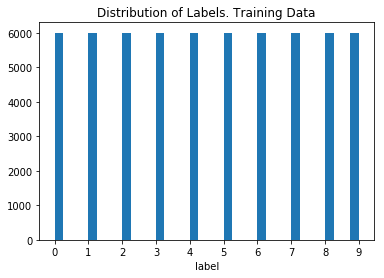

In [4]:
plt.hist(y_train, bins='auto')
plt.xticks(range(10))
plt.title("Distribution of Labels. Training Data")
plt.xlabel("label")

Visualize example image data

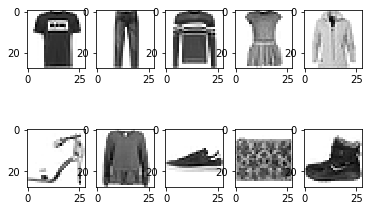

In [5]:
fig, ax = plt.subplots(2,5)
ax = ax.flatten()

for i in range(10):
    im_idx = np.argwhere(y_train == i).reshape(-1)[0]
    plottable_image = np.reshape(x_train[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

Let's normalize our data

In [6]:
scaled_x_train = (x_train / 255).reshape(x_train.shape[0], 28, 28, 1)
scaled_x_test = (x_test / 255).reshape(x_test.shape[0], 28, 28, 1)

print("scaled_x_train.shape", scaled_x_train.shape)
print("scaled_x_test.shape", scaled_x_test.shape)

scaled_x_train.shape (60000, 28, 28, 1)
scaled_x_test.shape (10000, 28, 28, 1)


# VAE

## Build&train model.

In [7]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

In [8]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [10]:
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [11]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [12]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

vae.fit(x=scaled_x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(scaled_x_test, None))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 301s 5ms/step - loss: 321.2760 - val_loss: 0.3400
Epoch 2/10
60000/60000 [==============================] - 220s 4ms/step - loss: 0.3359 - val_loss: 0.3340
Epoch 3/10
60000/60000 [==============================] - 221s 4ms/step - loss: 0.3317 - val_loss: 0.3328
Epoch 4/10
60000/60000 [==============================] - 233s 4ms/step - loss: 0.3295 - val_loss: 0.3312
Epoch 5/10
60000/60000 [==============================] - 217s 4ms/step - loss: 0.3280 - val_loss: 0.3284
Epoch 6/10
60000/60000 [==============================] - 240s 4ms/step - loss: 0.3269 - val_loss: 0.3288
Epoch 7/10
60000/60000 [==============================] - 229s 4ms/step - loss: 0.3260 - val_loss: 0.3278
Epoch 8/10
60000/60000 [==============================] - 251s 4ms/step - loss: 0.3253 - val_loss: 0.3271
Epoch 9/10
60000/60000 [==============================] - 225s 4ms/step - loss: 0.3248 - val_loss: 0

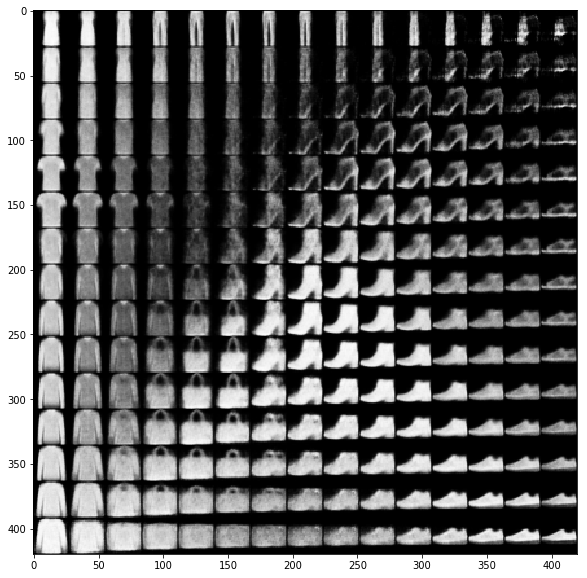

In [13]:
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Do you get a sensible continuous distribution?

The answer is Yes.
Each point of the two dimensional latent space is mapped to a 28x28 image by the decoder. Thus, we are dealing with a continuous distribution.
But is it sensible? Or, in other words, does every image representation of a coordinate in a latent space make sense?
Obviously, there are images, which are either too blurry or cannot be related to any fashion item.
However, most of image representations of the randomly chosen grid of points make sense for a human, see picture above. Therefore, the distribution is sensible.
Overall, we observe sensible and continuous distribution of latent space samples mapped to digit images.